<font color='black'>**Importing packages**</font>

In [133]:
## SYSTEM
import warnings
import requests
warnings.filterwarnings("ignore")
import itertools
import datetime
from datetime import datetime
import xlrd
import random
import sys
import math
import hdbscan
import re
from tqdm import tqdm

## DATA CLEANING
import numpy 
numpy.__version__ 
'1.21.4' 
import pandas as pd
pd.set_option('display.max_columns', None)

## CLUSTERING
from sklearn import cluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
import threadpoolctl

## GEO
import geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="YOUR_UNIQUE_NAME_TO_COMPLY_WITH_REQUESTS_LIMIT")
from geopy.distance import geodesic
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap
from collections import defaultdict
from ipywidgets import interactive

## GRAPHS
import plotly.express as px
import statsmodels.api as sm
import matplotlib
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
import seaborn as sns

<font color='black'>**I. Importing and cleaning delivery data**</font>

In [ ]:
## A) READING DELIVERIES DATA, REQUIRED PARAMS BELOW:
## 1) DELIVERY_DT
## 2) DELIVERY_ID
## 3) DELIVERY_CREATED_DTTM
## 4) CITY
## 5) ADDRESS
## 6) CLIENT_ID
delivery_data = pd.read_excel("~/FILE_PATH", 
                    parse_dates = True,
                    converters={'CLIENT_ID': str})
delivery_data.head()

In [ ]:
## A) READING COURIER ACTIVITIES DATA, REQUIRED PARAMS BELOW:
## 1) DELIVERY_DT
## 2) DELIVERY_START_DTTM
## 3) DELIVERY_END_DDTM
## 4) EMPLOYEE_ID
## 5) CLIENT_ID
courier_data = pd.read_excel("~/FILE_PATH", 
                    parse_dates = True,
                    converters={'CLIENT_ID': str})
courier_data.head()

In [ ]:
## MERGING CLIENT DATA WITH COURIER DATA
data = pd.merge(delivery_data, courier_data, on = ["CLIENT_ID", "DELIVERY_DT"])

In [236]:
## A) SPLITTING DATETIMES TO DATE AND TIME
## B) DELETING ADDRESS LIKE FLATS, ETC.
data['CREATE_DT'] = pd.to_datetime(data['DELIVERY_CREATED_DTTM']).dt.date
data['CREATE_TIME'] = pd.to_datetime(data['DELIVERY_CREATED_DTTM']).dt.time
data['ADDRESS'] = data['ADDRESS'].str.split(',').str[0:3].str.join(',')
data['LATITUDE'] = ""
data['LONGITUDE'] = ""
data.head()

,DELIVERY_DT,DELIVERY_ID,DELIVERY_CREATED_DTTM,CITY,ADDRESS,CLIENT_ID,DELIVERY_START_DTTM,DELIVERY_END_DTTM,EMPLOYEE_ID,CREATE_DT,CREATE_TIME,LATITUDE,LONGITUDE
0,2018-06-01,56102,2018-05-15 13:33:27,Санкт-Петербург,"Санкт-Петербург, Решетникова,17 к3",942702112866,2022-06-01 16:21:39,2022-06-01 16:23:46,316767,2018-05-15,13:33:27,,
1,2018-06-01,56342,2018-05-15 20:12:42,Санкт-Петербург,"Санкт-Петербург, проспект Космонавтов, 75",606481113057,2022-06-01 13:49:12,2022-06-01 13:52:30,60565,2018-05-15,20:12:42,,
2,2018-06-01,62232,2018-05-23 12:00:35,Санкт-Петербург,"Санкт-Петербург, Маршала Казакова,40 к1",700210114091,2022-06-01 12:00:40,2022-06-01 12:01:35,378815,2018-05-23,12:00:35,,
3,2018-06-01,65007,2018-05-27 17:33:27,Санкт-Петербург,"Санкт-Петербург, проспект Юрия Гагарина, 25",603562113032,2022-06-01 10:35:12,2022-06-01 10:40:34,316767,2018-05-27,17:33:27,,
4,2018-06-01,65252,2018-05-28 08:03:36,Санкт-Петербург,"Санкт-Петербург, Пражская,21",150932112862,2022-06-01 16:12:28,2022-06-01 16:15:21,60565,2018-05-28,08:03:36,,


In [237]:
## CHECKING DATA BEFORE GEOCODING
row_cnt_before_geo = "ROWS BEFORE GEOCODING: "+str(data['DELIVERY_ID'].count())+", DATES FROM "+str(data['DELIVERY_DT'].min())+" TO "+str(data['DELIVERY_DT'].max())+"."
row_cnt_before_geo

'ROWS BEFORE GEOCODING: 50, DATES FROM 2018-06-01 00:00:00 TO 2018-06-01 00:00:00.'

<font color='black'>**II. PUTTING DELIVERIES ON A MAP**</font>

In [238]:
## FINDING GEOCOORDINATES OF DELIVERIES (IF NOT FOUND - PUTTING NAN)
for i in data.index:
    try:
        location = geolocator.geocode(data['ADDRESS'][i])
        data.loc[i,'LATITUDE'] = location.latitude
        data.loc[i,'LONGITUDE'] = location.longitude
    except:
        data.loc[i,'LATITUDE'] = np.nan
        data.loc[i,'LONGITUDE'] = np.nan
data = data.replace(r'^\s*$', np.nan, regex=True)
data.head()

,DELIVERY_DT,DELIVERY_ID,DELIVERY_CREATED_DTTM,CITY,ADDRESS,CLIENT_ID,DELIVERY_START_DTTM,DELIVERY_END_DTTM,EMPLOYEE_ID,CREATE_DT,CREATE_TIME,LATITUDE,LONGITUDE
0,2018-06-01,56102,2018-05-15 13:33:27,Санкт-Петербург,"Санкт-Петербург, Решетникова,17 к3",942702112866,2022-06-01 16:21:39,2022-06-01 16:23:46,316767,2018-05-15,13:33:27,59.878408,30.333521
1,2018-06-01,56342,2018-05-15 20:12:42,Санкт-Петербург,"Санкт-Петербург, проспект Космонавтов, 75",606481113057,2022-06-01 13:49:12,2022-06-01 13:52:30,60565,2018-05-15,20:12:42,59.833263,30.359867
2,2018-06-01,62232,2018-05-23 12:00:35,Санкт-Петербург,"Санкт-Петербург, Маршала Казакова,40 к1",700210114091,2022-06-01 12:00:40,2022-06-01 12:01:35,378815,2018-05-23,12:00:35,59.859446,30.208025
3,2018-06-01,65007,2018-05-27 17:33:27,Санкт-Петербург,"Санкт-Петербург, проспект Юрия Гагарина, 25",603562113032,2022-06-01 10:35:12,2022-06-01 10:40:34,316767,2018-05-27,17:33:27,59.860128,30.334928
4,2018-06-01,65252,2018-05-28 08:03:36,Санкт-Петербург,"Санкт-Петербург, Пражская,21",150932112862,2022-06-01 16:12:28,2022-06-01 16:15:21,60565,2018-05-28,08:03:36,59.872018,30.390702


In [239]:
## CHECKING FOR EMPTY ROWS
data.isna().sum()

DELIVERY_DT              0
DELIVERY_ID              0
DELIVERY_CREATED_DTTM    0
CITY                     0
ADDRESS                  0
CLIENT_ID                0
DELIVERY_START_DTTM      0
DELIVERY_END_DTTM        0
EMPLOYEE_ID              0
CREATE_DT                0
CREATE_TIME              0
LATITUDE                 6
LONGITUDE                6
dtype: int64

In [240]:
## DELETING EMPTY ROWS
data = data[data['LATITUDE'].notna()]
data.reset_index(inplace = True, drop = True)
data.head()

,DELIVERY_DT,DELIVERY_ID,DELIVERY_CREATED_DTTM,CITY,ADDRESS,CLIENT_ID,DELIVERY_START_DTTM,DELIVERY_END_DTTM,EMPLOYEE_ID,CREATE_DT,CREATE_TIME,LATITUDE,LONGITUDE
0,2018-06-01,56102,2018-05-15 13:33:27,Санкт-Петербург,"Санкт-Петербург, Решетникова,17 к3",942702112866,2022-06-01 16:21:39,2022-06-01 16:23:46,316767,2018-05-15,13:33:27,59.878408,30.333521
1,2018-06-01,56342,2018-05-15 20:12:42,Санкт-Петербург,"Санкт-Петербург, проспект Космонавтов, 75",606481113057,2022-06-01 13:49:12,2022-06-01 13:52:30,60565,2018-05-15,20:12:42,59.833263,30.359867
2,2018-06-01,62232,2018-05-23 12:00:35,Санкт-Петербург,"Санкт-Петербург, Маршала Казакова,40 к1",700210114091,2022-06-01 12:00:40,2022-06-01 12:01:35,378815,2018-05-23,12:00:35,59.859446,30.208025
3,2018-06-01,65007,2018-05-27 17:33:27,Санкт-Петербург,"Санкт-Петербург, проспект Юрия Гагарина, 25",603562113032,2022-06-01 10:35:12,2022-06-01 10:40:34,316767,2018-05-27,17:33:27,59.860128,30.334928
4,2018-06-01,65252,2018-05-28 08:03:36,Санкт-Петербург,"Санкт-Петербург, Пражская,21",150932112862,2022-06-01 16:12:28,2022-06-01 16:15:21,60565,2018-05-28,08:03:36,59.872018,30.390702


In [241]:
## CHECKING DATA AFTER GEOCODING
row_cnt_after_geo = "ROWS AFTER GEOCODING: "+str(data['DELIVERY_ID'].count())+", DATES FROM "+str(data['DELIVERY_DT'].min())+" TO "+str(data['DELIVERY_DT'].max())+"."
print(row_cnt_before_geo, '\n', row_cnt_after_geo)

ROWS BEFORE GEOCODING: 50, DATES FROM 2018-06-01 00:00:00 TO 2018-06-01 00:00:00. 
 ROWS AFTER GEOCODING: 44, DATES FROM 2018-06-01 00:00:00 TO 2018-06-01 00:00:00.


In [242]:
## SAVING DATAFRAME TO CSV NOT TO START GEOCODING FROM THE BEGGINNING
city = ' '.join(map(str, data["CITY"].unique()))
hx1 = '%012x' % random.randrange(16**12)
export_datetime1 = datetime.now()
export_datetime1 = export_datetime1.strftime("%d-%m-%Y_%H:%M:%S")
data.to_excel('RAW_GEO_DATA_FOR_'+city+'_'+hx1.lower()+'_'+str(export_datetime1)+'.xlsx')

In [243]:
## PUTTING DELIVERIES ON A HEATMAP
data_heatmap = folium.Map(location=[data['LATITUDE'].mean(), 
                                data['LONGITUDE'].mean()], 
                                zoom_start=10, 
                                tiles = "Stamen Terrain", 
                                control_scale=True)
data['LATITUDE'] = data['LATITUDE'].astype(float)
data['LONGITUDE'] = data['LONGITUDE'].astype(float)
data_coordinates = data[['LATITUDE', 'LONGITUDE']]
data_coordinates_rows = [[row['LATITUDE'],row['LONGITUDE']] for index, row in data_coordinates.iterrows()]
HeatMap(data_coordinates_rows).add_to(data_heatmap)
data_heatmap

In [244]:
## PUTTING DELIVERIES ON A REGULAR MAP
data_map = folium.Map(location=[data['LATITUDE'].mean(), 
                                data['LONGITUDE'].mean()], 
                                zoom_start=10, 
                                tiles = "Stamen Terrain", 
                                control_scale=True)
for index, location_info in data.iterrows():
    folium.Marker([location_info["LATITUDE"], 
                   location_info["LONGITUDE"]], 
                   popup=location_info["DELIVERY_ID"],
                   icon=folium.Icon(color='darkgreen', icon='flag', prefix='fa')).add_to(data_map)
data_map

In [245]:
## A) SORTING DATA BY DELIVERY_DT, EMPLOYEE_ID AND DELIVERY_START_DDTM
## B) CALCULATING KM AND TIME TO NEXT POINT
## C) CALCULATING COURIER SPEED
data_pre_final = data.copy()
data_pre_final.sort_values(['DELIVERY_DT', 'EMPLOYEE_ID', 'DELIVERY_START_DTTM'], ascending=[True, True, True], inplace=True)
data_pre_final.reset_index(inplace = True, drop = True)
data_pre_final['KM_TO_NEXT_POINT'] = ""
data_pre_final['TIME_TO_NEXT_POINT'] = ""
for i in range(len(data_pre_final)-1):
    if str(data_pre_final['EMPLOYEE_ID'][i]) == str(data_pre_final['EMPLOYEE_ID'][i+1]) and str(data_pre_final['DELIVERY_DT'][i]) == str(data_pre_final['DELIVERY_DT'][i+1]):
        coordinates_1 = [data_pre_final['LATITUDE'][i], data_pre_final['LONGITUDE'][i]]
        coordinates_2 = [data_pre_final['LATITUDE'][i+1], data_pre_final['LONGITUDE'][i+1]]
        distance_km = geodesic(coordinates_1, coordinates_2).km
        data_pre_final.loc[i, "KM_TO_NEXT_POINT"] = distance_km
        delivery_end = pd.to_datetime(data_pre_final['DELIVERY_START_DTTM'][i+1])
        delivery_start = pd.to_datetime(data_pre_final['DELIVERY_END_DTTM'][i])
        time_to_next_point = delivery_end - delivery_start
        data_pre_final.loc[i, "TIME_TO_NEXT_POINT"] = time_to_next_point
    else:
        data_pre_final.at[i, 'KM_TO_NEXT_POINT'] = np.nan
        data_pre_final.at[i, 'TIME_TO_NEXT_POINT'] = np.nan
data_pre_final = data_pre_final.replace(r'^\s*$', np.nan, regex=True)
data_pre_final = data_pre_final[data_pre_final['KM_TO_NEXT_POINT'].notna()]
data_pre_final[data_pre_final['KM_TO_NEXT_POINT'] != '0']
data_pre_final.reset_index(inplace = True, drop = True)
for i in range(len(data_pre_final)-1):
    hours_to_next_point = data_pre_final['TIME_TO_NEXT_POINT'][i].total_seconds()/3600
    data_pre_final.loc[i, "HOURS_TO_NEXT_POINT"] = hours_to_next_point
for i in range(len(data_pre_final)-1):
    km_per_hour = data_pre_final['KM_TO_NEXT_POINT'][i] / data_pre_final['HOURS_TO_NEXT_POINT'][i]
    data_pre_final.loc[i, "KM_PER_HOUR"] = km_per_hour
data_pre_final.head()

,DELIVERY_DT,DELIVERY_ID,DELIVERY_CREATED_DTTM,CITY,ADDRESS,CLIENT_ID,DELIVERY_START_DTTM,DELIVERY_END_DTTM,EMPLOYEE_ID,CREATE_DT,CREATE_TIME,LATITUDE,LONGITUDE,KM_TO_NEXT_POINT,TIME_TO_NEXT_POINT,HOURS_TO_NEXT_POINT,KM_PER_HOUR
0,2018-06-01,66251,2018-05-29 21:14:09,Санкт-Петербург,"Санкт-Петербург, Карпатская, 18",449406125749,2022-06-01 11:28:39,2022-06-01 11:33:36,60565,2018-05-29,21:14:09,59.831738,30.434900,5.831807,0 days 00:39:32,0.658889,8.850971
1,2018-06-01,66459,2018-05-30 10:27:16,Санкт-Петербург,"Санкт-Петербург, Будапештская, 85",166566113023,2022-06-01 12:13:08,2022-06-01 12:17:42,60565,2018-05-30,10:27:16,59.871744,30.367799,4.310138,0 days 01:31:30,1.525000,2.826320
2,2018-06-01,56342,2018-05-15 20:12:42,Санкт-Петербург,"Санкт-Петербург, проспект Космонавтов, 75",606481113057,2022-06-01 13:49:12,2022-06-01 13:52:30,60565,2018-05-15,20:12:42,59.833263,30.359867,4.307251,0 days 01:54:22,1.906111,2.259706
3,2018-06-01,66655,2018-05-30 13:41:10,Санкт-Петербург,"Санкт-Петербург, Бухарестская, 76 к1",654664112944,2022-06-01 15:46:52,2022-06-01 15:48:41,60565,2018-05-30,13:41:10,59.870131,30.383003,0.479799,0 days 00:23:47,0.396389,1.210425
4,2018-06-01,65252,2018-05-28 08:03:36,Санкт-Петербург,"Санкт-Петербург, Пражская,21",150932112862,2022-06-01 16:12:28,2022-06-01 16:15:21,60565,2018-05-28,08:03:36,59.872018,30.390702,3.551148,0 days 01:18:15,1.304167,2.722925


<font color='black'>**III. SETTING PARAMETERES FOR CLUSTERING**</font>

In [246]:
## HARDCODING COURIER WORKTIME START AND END
work_day_start = 10
work_day_end = 18
work_day_h = work_day_end - work_day_start
print("COURIER WORKDAY CONSISTS OF "+str(work_day_h)+" HOURS.")

COURIER WORKDAY CONSISTS OF 8 HOURS.


In [247]:
## CALCULATING DELIVERIES TIMESTATS IN 2H
order_time = data.copy()
order_time['QTY'] = 1
order_time.drop(order_time.columns.difference(['DELIVERY_CREATED_DTTM','QTY']), 1, inplace=True)
order_time.set_index('DELIVERY_CREATED_DTTM', inplace=True)
order_time = order_time.resample('2H').count()
order_time.reset_index(inplace=True)
order_time['DELIVERY_CREATED_TIME'] = pd.to_datetime(order_time['DELIVERY_CREATED_DTTM']).dt.time
order_time = order_time.groupby(['DELIVERY_CREATED_TIME']).mean()
mean_sum = order_time['QTY'].sum()
order_time['PERCENTAGE'] = order_time['QTY'] / mean_sum * 100
order_time = order_time.drop(columns = ['QTY'])
order_time.reset_index(inplace=True)
order_time.head(20)

,DELIVERY_CREATED_TIME,PERCENTAGE
0,00:00:00,0.000000
1,02:00:00,0.000000
2,04:00:00,0.000000
3,06:00:00,2.258905
4,08:00:00,15.812337
5,10:00:00,13.553432
6,12:00:00,24.847958
7,14:00:00,11.728931
8,16:00:00,4.691573
9,18:00:00,6.776716


In [248]:
## VISUALIZING ON A PLOT
order_time_plot = px.line(order_time, x = "DELIVERY_CREATED_TIME", y = "PERCENTAGE", title = 'DELIVERY ORDER TIMESTATS')
order_time_plot.show()

In [249]:
## RECALCULATING CARD ORDER TIMESTATS ACCORDING TO COURIERS' WORKTIME
order_work_time = order_time.copy()
for i in range(len(order_work_time)):
    order_hours_start = work_day_start - 2
    order_hours_end = work_day_end - 2
    if order_work_time.loc[i, 'DELIVERY_CREATED_TIME'].hour < order_hours_start or order_work_time.loc[i, 'DELIVERY_CREATED_TIME'].hour > order_hours_end:
        order_work_time.loc[i, 'WORK_TIME_FLG'] = 0
    else:
        order_work_time.loc[i, 'WORK_TIME_FLG'] = 1
order_work_time.work_time_flg = order_work_time['WORK_TIME_FLG'].astype(int)
work_time_grp = order_work_time.groupby('WORK_TIME_FLG')
unwork_time_grp = pd.DataFrame(work_time_grp.apply(lambda x: x[x['WORK_TIME_FLG'] == 0]['PERCENTAGE'].sum()))
unwork_time_grp.columns = ['PERCENTAGE_SUM']
unwork_time_percentage = unwork_time_grp['PERCENTAGE_SUM'].iloc[0]
unwork_time_percentage
work_time_intervals = pd.DataFrame(order_work_time.groupby('WORK_TIME_FLG')['WORK_TIME_FLG'].apply(lambda x: (x==0).count()))
work_time_intervals.columns = ['CNT']
added_time = unwork_time_percentage / work_time_intervals['CNT'].iloc[1]
for i in range(len(order_work_time)):
    if order_work_time.work_time_flg[i] == 0:
        order_work_time.loc[i, 'PERCENTAGE_WORKTIME'] = 0.0
    elif order_work_time.work_time_flg[i] == 1:
        order_work_time.loc[i, 'PERCENTAGE_WORKTIME'] = order_work_time['PERCENTAGE'][i] + added_time
order_work_time.percentage_new = order_work_time['PERCENTAGE_WORKTIME'].astype(float)
order_work_time

,DELIVERY_CREATED_TIME,PERCENTAGE,WORK_TIME_FLG,PERCENTAGE_WORKTIME
0,00:00:00,0.000000,0.0,0.000000
1,02:00:00,0.000000,0.0,0.000000
2,04:00:00,0.000000,0.0,0.000000
3,06:00:00,2.258905,0.0,0.000000
4,08:00:00,15.812337,1.0,21.685491
5,10:00:00,13.553432,1.0,19.426586
6,12:00:00,24.847958,1.0,30.721112
7,14:00:00,11.728931,1.0,17.602085
8,16:00:00,4.691573,1.0,10.564726
9,18:00:00,6.776716,0.0,0.000000


In [250]:
## REBUILDING PLOT
order_work_time_plot = px.line(order_work_time, x = "DELIVERY_CREATED_TIME", y = "PERCENTAGE", title = 'DELIVERY ORDER TIMESTATS (WORKTIME ONLY)')
order_work_time_plot.show()

In [251]:
## CALCULATING CUMSUM ORDERS PERCENTAGE (WE WILL NEED IT IN THE FUTURE)
order_work_time_cumsum = order_work_time.copy()
order_work_time_cumsum = order_work_time_cumsum.loc[(order_work_time_cumsum['PERCENTAGE_WORKTIME'] > 0)]
order_work_time_cumsum = order_work_time_cumsum.drop(columns = (['PERCENTAGE', 'WORK_TIME_FLG']))
order_work_time_cumsum.reset_index(inplace = True, drop = True)
order_work_time_cumsum["PERCENTAGE_CUMSUM"] = np.cumsum(order_work_time_cumsum.PERCENTAGE_WORKTIME)
order_work_time_cumsum

,DELIVERY_CREATED_TIME,PERCENTAGE_WORKTIME,PERCENTAGE_CUMSUM
0,08:00:00,21.685491,21.685491
1,10:00:00,19.426586,41.112076
2,12:00:00,30.721112,71.833189
3,14:00:00,17.602085,89.435274
4,16:00:00,10.564726,100.000000


In [252]:
## CALCULATING AVERAGE DELIVERIES NUMBER (COULD BE HARDCODED TO TEST THE MODEL ON MORE DELIVERIES THAN ARE IN RETRO DATA)
avg_del_cnt = pd.DataFrame(data['DELIVERY_ID'].groupby(data['DELIVERY_DT']).count())
avg_del_cnt = avg_del_cnt.mean().round(0)
avg_del_cnt = round(int(avg_del_cnt))
print("AVERAGE AMOUNT OF DELIVERIES MADE IN "+city+" IS "+str(avg_del_cnt)+" DELIVERIES PER DAY.")

AVERAGE AMOUNT OF DELIVERIES MADE IN Санкт-Петербург IS 44 DELIVERIES PER DAY.


In [253]:
## CALCULATING MEAN OF CLIENT CONTACT TIME
delivery_start = pd.to_datetime(data['DELIVERY_START_DTTM'])
delivery_end = pd.to_datetime(data['DELIVERY_END_DTTM'])
client_contact_time = delivery_end - delivery_start
mean_client_contact_time = client_contact_time.mean()
mean_client_contact_time
mean_client_contact_time_seconds_total = mean_client_contact_time.seconds
mean_client_contact_time_hours_total = mean_client_contact_time_seconds_total/3600
mean_client_contact_time_seconds = mean_client_contact_time_seconds_total%60
mean_client_contact_time_hours = mean_client_contact_time_seconds_total//3600
mean_client_contact_time_minutes = (mean_client_contact_time_seconds_total//60)%60
print("AVERAGE CLIENT CONTACT TIME IS "+str(mean_client_contact_time_minutes)+' MIN AND '+str(mean_client_contact_time_seconds)+" SEC.")

AVERAGE CLIENT CONTACT TIME IS 6 MIN AND 7 SEC.


In [254]:
## CALCULATING COURIER'S MEAN SPEED
mean_km_per_hour = data_pre_final['KM_PER_HOUR'].mean()
print("AVERAGE SPEED OF COURIER IS "+str(round(mean_km_per_hour,2))+" KM PER HOUR.")

AVERAGE SPEED OF COURIER IS 3.88 KM PER HOUR.


In [255]:
## HARDCODING COUNT OF DELIVERY HUB VISITS COURIER NEEDS
hub_visit_freq = 3
hub_visit_min = 30
hub_visit_h = hub_visit_min/60
print("TIME FOR VISITING DELIVERY HUB "+str(hub_visit_min)+" MINUTES, IT IS NEEDED FOR EVERY "+str(hub_visit_freq)+" DELIVERY.")

TIME FOR VISITING DELIVERY HUB 30 MINUTES, IT IS NEEDED FOR EVERY 3 DELIVERY.


In [272]:
## HARDCODING COST OF COURIER'S MINUTE
cost_of_min_courier = 8
cost_of_h_courier = cost_of_min_courier * 60
cost_of_d_courier = cost_of_h_courier * work_day_h
print("COST OF COURIER'S DAY USED IN MODEL IS:"+"\n"+str(round(cost_of_min_courier,2))+" RUB/MIN."+"\n"+str(round(cost_of_h_courier,2))+" RUB/HOUR."+"\n"+str(round(cost_of_d_courier,2))+" RUB/DAY.")

COST OF COURIER'S DAY USED IN MODEL IS:
8 RUB/MIN.
480 RUB/HOUR.
3840 RUB/DAY.


<font color='black'>**IV. CLUSTERING OUR DELIVERIES**</font>

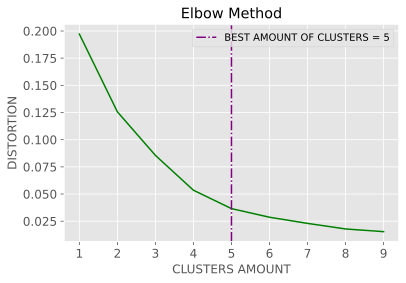

In [257]:
## USING ELBOW METHOD TO DETERMINE NUMBER OF CLUSTERS
X = data_pre_final[["LATITUDE","LONGITUDE"]]
max_k = 10
distortions = [] 
for i in range(2, max_k+1):
    if len(X) >= i:
        model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        model.fit(X)
        distortions.append(model.inertia_)
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions, color='green')
ax.axvline(k, ls='-.', color="purple", label="BEST AMOUNT OF CLUSTERS = "+str(k))
ax.set(title='Elbow Method', xlabel='CLUSTERS AMOUNT', ylabel="DISTORTION")
ax.legend()
ax.grid(True)
plt.show()

In [258]:
## DETERMINING CLUSTER FOR EVERY DELIVIERY WE HAD IN THE PAST WITH DROPPING NAN
model = cluster.KMeans(n_clusters=k, init='k-means++')
data_pre_final["CLUSTER"] = model.fit_predict(X)
data_pre_final.dropna(inplace=True)
data_pre_final.head()

,DELIVERY_DT,DELIVERY_ID,DELIVERY_CREATED_DTTM,CITY,ADDRESS,CLIENT_ID,DELIVERY_START_DTTM,DELIVERY_END_DTTM,EMPLOYEE_ID,CREATE_DT,CREATE_TIME,LATITUDE,LONGITUDE,KM_TO_NEXT_POINT,TIME_TO_NEXT_POINT,HOURS_TO_NEXT_POINT,KM_PER_HOUR,CLUSTER
0,2018-06-01,66251,2018-05-29 21:14:09,Санкт-Петербург,"Санкт-Петербург, Карпатская, 18",449406125749,2022-06-01 11:28:39,2022-06-01 11:33:36,60565,2018-05-29,21:14:09,59.831738,30.434900,5.831807,0 days 00:39:32,0.658889,8.850971,0
1,2018-06-01,66459,2018-05-30 10:27:16,Санкт-Петербург,"Санкт-Петербург, Будапештская, 85",166566113023,2022-06-01 12:13:08,2022-06-01 12:17:42,60565,2018-05-30,10:27:16,59.871744,30.367799,4.310138,0 days 01:31:30,1.525000,2.826320,1
2,2018-06-01,56342,2018-05-15 20:12:42,Санкт-Петербург,"Санкт-Петербург, проспект Космонавтов, 75",606481113057,2022-06-01 13:49:12,2022-06-01 13:52:30,60565,2018-05-15,20:12:42,59.833263,30.359867,4.307251,0 days 01:54:22,1.906111,2.259706,1
3,2018-06-01,66655,2018-05-30 13:41:10,Санкт-Петербург,"Санкт-Петербург, Бухарестская, 76 к1",654664112944,2022-06-01 15:46:52,2022-06-01 15:48:41,60565,2018-05-30,13:41:10,59.870131,30.383003,0.479799,0 days 00:23:47,0.396389,1.210425,1
4,2018-06-01,65252,2018-05-28 08:03:36,Санкт-Петербург,"Санкт-Петербург, Пражская,21",150932112862,2022-06-01 16:12:28,2022-06-01 16:15:21,60565,2018-05-28,08:03:36,59.872018,30.390702,3.551148,0 days 01:18:15,1.304167,2.722925,1


<AxesSubplot:xlabel='LATITUDE', ylabel='LONGITUDE'>

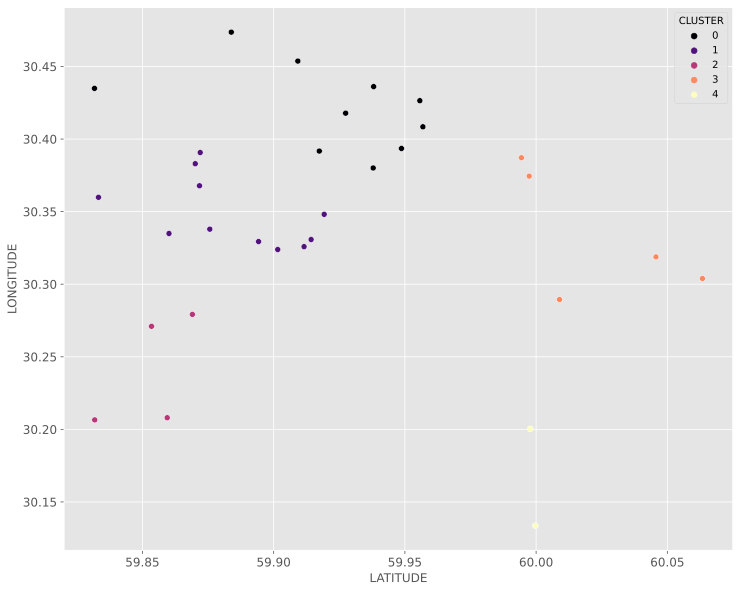

In [259]:
## VISUALIZING CLUSTERS
plt.figure(figsize=(12,10))
sns.scatterplot(x=data_pre_final["LATITUDE"],y= data_pre_final["LONGITUDE"],hue=data_pre_final["CLUSTER"],palette="magma")

In [260]:
## CALCULATING CLUSTER CENTERS
data_clusters = data_pre_final.drop(data_pre_final.columns.difference(['CLUSTER','LATITUDE', 'LONGITUDE']), 1, inplace=True)
data_clusters = data_pre_final.groupby("CLUSTER").mean()
data_clusters.reset_index(inplace = True)
data_clusters

,CLUSTER,LATITUDE,LONGITUDE
0,0,59.920692,30.421633
1,1,59.883990,30.348384
2,2,59.853445,30.241189
3,3,60.021938,30.334755
4,4,59.998736,30.166999


In [261]:
## PUTTING CLUSTER CENTERS ON A MAP
cluster_map = folium.Map(location=[data_clusters['LATITUDE'].mean(), 
                                data_clusters['LONGITUDE'].mean()], 
                                zoom_start=10, 
                                tiles = "Stamen Terrain", 
                                control_scale=True)
for index, location_info in data_clusters.iterrows():
    folium.Marker([location_info['LATITUDE'], 
                   location_info['LONGITUDE']], 
                   icon=folium.Icon(color='darkgreen', icon='flag', prefix='fa')).add_to(cluster_map)
cluster_map

In [262]:
## LOOKING AT ADDRESSES DISTRIBUTION WITHIN CLUSTERS
clusters_cnt = data_clusters['CLUSTER'].count()
clusters_cnt = int(clusters_cnt)
cluster_size = pd.DataFrame(data_pre_final.groupby('CLUSTER').size())
cluster_size.reset_index(inplace = True)
cluster_size = cluster_size.rename(columns = {0:'DELIVERIES_TOTAL'})
cluster_size['DELIVERIES_DAILY'] = round(avg_del_cnt * cluster_size['DELIVERIES_TOTAL'] / cluster_size['DELIVERIES_TOTAL'].sum())
cluster_size['DELIVERIES_DAILY'] = cluster_size['DELIVERIES_DAILY'].astype(int)
cluster_size['CLUSTER_PERCENTAGE'] = cluster_size['DELIVERIES_TOTAL'] / cluster_size['DELIVERIES_TOTAL'].sum()
print("AVERAGE DELIVERIES PER DAY: ", avg_del_cnt, ", CLUSTERS CNT: ", clusters_cnt, ".")
cluster_size

AVERAGE DELIVERIES PER DAY:  44 , CLUSTERS CNT:  5 .


,CLUSTER,DELIVERIES_TOTAL,DELIVERIES_DAILY,CLUSTER_PERCENTAGE
0,0,10,14,0.31250
1,1,11,15,0.34375
2,2,4,6,0.12500
3,3,5,7,0.15625
4,4,2,3,0.06250


<font color='black'>**V. RUNNING OUR MODEL ON RANDOM COORDINATES IN DEFINED CLUSTERS**</font>

In [263]:
## RANDOMIZING COORDINATES IN DEFINED CLUSTERS
latitude = data_clusters['LATITUDE']
longitude = data_clusters['LONGITUDE']
num_rows = cluster_size['DELIVERIES_DAILY']
dataframes = []
for i in range(0, clusters_cnt):
    for j in range(num_rows[i]):
        rnd_lat = random.random()/15
        rnd_lon = random.random()/15
        rnd_geo = {'CLUSTER': [i], 'LATITUDE':  latitude[i]+rnd_lat, 'LONGITUDE': longitude[i]+rnd_lon}
        data_rnd_geo = pd.DataFrame(rnd_geo, index=[0])
        dataframes.append(data_rnd_geo)
data_rnd_coordinates = pd.DataFrame(np.concatenate(dataframes))
data_rnd_coordinates = data_rnd_coordinates.rename(columns = {0: 'CLUSTER', 1: 'LATITUDE', 2: 'LONGITUDE'})
data_rnd_coordinates['CLUSTER'] = data_rnd_coordinates['CLUSTER'].astype(int)
data_rnd_coordinates.head()

,CLUSTER,LATITUDE,LONGITUDE
0,0,59.980403,30.428575
1,0,59.939120,30.439496
2,0,59.968476,30.479950
3,0,59.968329,30.445192
4,0,59.961947,30.458588


In [264]:
## PUTTING RANDOM COORDINATES ON A MAP
rnd_coordinates_map = folium.Map(location=[data_rnd_coordinates['LATITUDE'].mean(), 
                                data_rnd_coordinates['LONGITUDE'].mean()], 
                                zoom_start=10, 
                                tiles = "Stamen Terrain", 
                                control_scale=True)
for index, location_info in data_rnd_coordinates.iterrows():
    folium.Marker([location_info['LATITUDE'], 
                   location_info['LONGITUDE']], 
                   icon=folium.Icon(color='darkgreen', icon='flag', prefix='fa')).add_to(rnd_coordinates_map)
rnd_coordinates_map

In [265]:
## CALCULATING DELIVERY TIME & SPEED FOR RANDOM POINTS BASED ON PARAMETERS FROM STEP II AND CALCULATING NUMBER OF COURIERS TO PERFORM THE DELIVERIES
data_rnd_coordinates.sort_values(['CLUSTER'], ascending=[True], inplace=True)
data_rnd_coordinates.reset_index(inplace = True, drop = True)
data_rnd_coordinates['DELIVERY_NO_IN_CLUSTER'] = data_rnd_coordinates.groupby('CLUSTER')['CLUSTER'].rank(method="first", ascending=True)
data_rnd_coordinates['DELIVERY_NO_IN_CLUSTER'] = data_rnd_coordinates['DELIVERY_NO_IN_CLUSTER'].astype(int)
data_rnd_coordinates['DELIVERY_NO_IN_CLUSTER_CUMSUM'] = 100 * data_rnd_coordinates['DELIVERY_NO_IN_CLUSTER'] / data_rnd_coordinates.groupby('CLUSTER')['CLUSTER'].transform('count')
data_rnd_coordinates['KM_TO_NEXT_POINT'] = ""
data_rnd_coordinates['H_TO_NEXT_POINT'] = ""
data_rnd_coordinates['H_TO_NEXT_POINT_W_CONTACT'] = ""
data_rnd_coordinates['HUB_VISIT_NEED'] = ""
data_rnd_coordinates['H_TO_NEXT_POINT_W_CONTACT_W_HUB'] = ""
data_rnd_coordinates['H_CUMSUM'] = ""
for i in range(len(data_rnd_coordinates)-1):
    if data_rnd_coordinates['CLUSTER'][i] == data_rnd_coordinates['CLUSTER'][i+1]:
        coordinates_1 = [data_rnd_coordinates['LATITUDE'][i], data_rnd_coordinates['LONGITUDE'][i]]
        coordinates_2 = [data_rnd_coordinates['LATITUDE'][i+1], data_rnd_coordinates['LONGITUDE'][i+1]]
        distance_km = geodesic(coordinates_1, coordinates_2).km
        data_rnd_coordinates.loc[i, 'KM_TO_NEXT_POINT'] = distance_km
        h_to_next_point = distance_km / mean_km_per_hour
        data_rnd_coordinates.loc[i, 'H_TO_NEXT_POINT'] = h_to_next_point
        h_to_next_point_w_contact = h_to_next_point + mean_client_contact_time_hours_total
        data_rnd_coordinates.loc[i, 'H_TO_NEXT_POINT_W_CONTACT'] = h_to_next_point_w_contact
        if data_rnd_coordinates['DELIVERY_NO_IN_CLUSTER'][i] % hub_visit_freq == 0:
            data_rnd_coordinates.loc[i, 'HUB_VISIT_NEED'] = 1
        else:
            data_rnd_coordinates.loc[i, 'HUB_VISIT_NEED'] = 0
        if data_rnd_coordinates['HUB_VISIT_NEED'][i] > 0:
            data_rnd_coordinates.loc[i, 'H_TO_NEXT_POINT_W_CONTACT_W_HUB'] = h_to_next_point_w_contact + hub_visit_h
        else:
            data_rnd_coordinates.loc[i, 'H_TO_NEXT_POINT_W_CONTACT_W_HUB'] = h_to_next_point_w_contact
    else:
        data_rnd_coordinates.at[i, 'KM_TO_NEXT_POINT'] = 0.0
        data_rnd_coordinates.at[i, 'H_TO_NEXT_POINT'] = 0.0
        data_rnd_coordinates.at[i, 'H_TO_NEXT_POINT_W_CONTACT'] = 0.0
        data_rnd_coordinates.at[i, 'HUB_VISIT_NEED'] = np.nan
        data_rnd_coordinates.at[i, 'H_TO_NEXT_POINT_W_CONTACT_W_HUB'] = 0.0
data_rnd_coordinates['KM_TO_NEXT_POINT'].iloc[-1] = 0.0
data_rnd_coordinates['H_TO_NEXT_POINT'].iloc[-1] = 0.0
data_rnd_coordinates['H_TO_NEXT_POINT_W_CONTACT'].iloc[-1] = 0.0
data_rnd_coordinates['HUB_VISIT_NEED'].iloc[-1] = np.nan
data_rnd_coordinates['H_TO_NEXT_POINT_W_CONTACT_W_HUB'].iloc[-1] = 0.0
data_rnd_coordinates['H_TO_NEXT_POINT_W_CONTACT_W_HUB'] = data_rnd_coordinates['H_TO_NEXT_POINT_W_CONTACT_W_HUB'].astype(float)
data_rnd_coordinates["H_CUMSUM"] = data_rnd_coordinates.groupby(['CLUSTER'])['H_TO_NEXT_POINT_W_CONTACT_W_HUB'].cumsum(axis=0)
data_rnd_coordinates['COURIER_NO'] = (data_rnd_coordinates['H_CUMSUM'] // work_day_h) + 1
data_rnd_coordinates['COURIER_NO'] = data_rnd_coordinates['COURIER_NO'].astype(int)
data_rnd_coordinates.head(50)

,CLUSTER,LATITUDE,LONGITUDE,DELIVERY_NO_IN_CLUSTER,DELIVERY_NO_IN_CLUSTER_CUMSUM,KM_TO_NEXT_POINT,H_TO_NEXT_POINT,H_TO_NEXT_POINT_W_CONTACT,HUB_VISIT_NEED,H_TO_NEXT_POINT_W_CONTACT_W_HUB,H_CUMSUM,COURIER_NO
0,0,59.980403,30.428575,1,7.142857,1.595983,0.411665,0.51361,0,0.513610,0.513610,1
1,0,59.976356,30.455994,2,14.285714,4.389034,1.1321,1.234044,0,1.234044,1.747654,1
2,0,59.937653,30.441332,3,21.428571,5.008714,1.291939,1.393883,1,1.893883,3.641537,1
3,0,59.982123,30.428169,4,28.571429,5.726483,1.477079,1.579024,0,1.579024,5.220561,1
4,0,59.934369,30.466081,5,35.714286,4.88224,1.259317,1.361261,0,1.361261,6.581822,1
5,0,59.978108,30.460737,6,42.857143,6.359848,1.640448,1.742393,1,2.242393,8.824215,2
6,0,59.921157,30.468501,7,50.000000,6.532661,1.685023,1.786968,0,1.786968,10.611183,2
7,0,59.975171,30.423015,8,57.142857,5.777328,1.490194,1.592138,0,1.592138,12.203321,2
8,0,59.924644,30.446271,9,64.285714,4.212536,1.086574,1.188519,1,1.688519,13.891840,2
9,0,59.961947,30.458588,10,71.428571,1.032315,0.266274,0.368218,0,0.368218,14.260058,2


In [266]:
## PREDICTING ORDER TIME BASED ON RETRO-DATA FROM STEP II
data_rnd_coordinates.sort_values(['DELIVERY_NO_IN_CLUSTER_CUMSUM'], ascending=[True], inplace=True)
order_work_time_cumsum.sort_values(['PERCENTAGE_CUMSUM'], ascending=[True], inplace=True)
data_final = pd.merge_asof(data_rnd_coordinates, order_work_time_cumsum, left_on='DELIVERY_NO_IN_CLUSTER_CUMSUM', right_on = 'PERCENTAGE_CUMSUM', direction='nearest')
data_final.sort_values(['CLUSTER', 'DELIVERY_NO_IN_CLUSTER'], ascending=[True, True], inplace=True)
data_final = data_final.drop(columns = (['PERCENTAGE_WORKTIME', 'PERCENTAGE_CUMSUM']))
data_final.reset_index(inplace = True, drop = True)
data_final.head()

,CLUSTER,LATITUDE,LONGITUDE,DELIVERY_NO_IN_CLUSTER,DELIVERY_NO_IN_CLUSTER_CUMSUM,KM_TO_NEXT_POINT,H_TO_NEXT_POINT,H_TO_NEXT_POINT_W_CONTACT,HUB_VISIT_NEED,H_TO_NEXT_POINT_W_CONTACT_W_HUB,H_CUMSUM,COURIER_NO,DELIVERY_CREATED_TIME
0,0,59.980403,30.428575,1,7.142857,1.595983,0.411665,0.51361,0,0.513610,0.513610,1,08:00:00
1,0,59.976356,30.455994,2,14.285714,4.389034,1.1321,1.234044,0,1.234044,1.747654,1,08:00:00
2,0,59.937653,30.441332,3,21.428571,5.008714,1.291939,1.393883,1,1.893883,3.641537,1,08:00:00
3,0,59.982123,30.428169,4,28.571429,5.726483,1.477079,1.579024,0,1.579024,5.220561,1,08:00:00
4,0,59.934369,30.466081,5,35.714286,4.88224,1.259317,1.361261,0,1.361261,6.581822,1,10:00:00


<font color='black'>**VI. CONCLUSIONS**</font>

In [267]:
## CALCULATING COURIER NUMBER
courier_cnt = pd.DataFrame(data_final.groupby(['CLUSTER'], sort=False)['COURIER_NO'].max())
courier_cnt.sort_values(['CLUSTER'], ascending=[True], inplace=True)
courier_cnt.reset_index(inplace = True)
courier_needed_cnt = sum(courier_cnt['COURIER_NO'])
print("COURIER NUMBER NEEDED TO PERFORM THE DELIVERIES: ", courier_needed_cnt, ".")
courier_cnt

COURIER NUMBER NEEDED TO PERFORM THE DELIVERIES:  8 .


,CLUSTER,COURIER_NO
0,0,3
1,1,2
2,2,1
3,3,1
4,4,1


In [268]:
## CALCULATING DELIVERY COSTS FOR 2 TYPES OF DELIVERIES: A) 2H REGULAR DELIVERY B) 15MIN FAST DELIVERY
df_list = %who_ls DataFrame
if 'data_tariff' not in df_list: 
    data_tariff = pd.DataFrame(columns = ['AVG_DEL_CNT', 'COURIER_NEEDED_CNT', 'COURIER_PERFORMANCE', 'AVG_TARIFF_2H', 'AVG_TARIFF_15MIN', 'CALC_DTTM'])
avg_work_time = data_final.groupby(['CLUSTER'], sort=False)['H_CUMSUM'].max().mean()
avg_no_work_time = work_day_h - avg_work_time
work_time_percent = ((avg_work_time * 100 / work_day_h)) / 100
no_work_time_percent = 1 - work_time_percent
avg_tariff_2h = cost_of_d_courier * courier_needed_cnt / round(avg_del_cnt * 1) * (1 + no_work_time_percent)
avg_tariff_2h = round(avg_tariff_2h,2)
h_model_mean_client_contact = data_final['H_TO_NEXT_POINT_W_CONTACT_W_HUB'].mean()
coeff_2h = 8 / h_model_mean_client_contact
coeff_15min = 8 * 60 / (15+mean_client_contact_time_hours_total*60)
markup_15min = coeff_15min / coeff_2h
avg_tariff_15min = avg_tariff_2h * markup_15min
avg_tariff_15min = round(avg_tariff_15min,2)
courier_performance = avg_del_cnt / courier_needed_cnt
courier_performance = round(courier_performance,2)
calc_dttm = datetime.now()
calc_dttm = calc_dttm.strftime("%d/%m/%Y %H:%M:%S")
data_tariff = data_tariff.append({'AVG_DEL_CNT' : avg_del_cnt, 'COURIER_NEEDED_CNT' : courier_needed_cnt, 'COURIER_PERFORMANCE' : courier_performance, 'AVG_TARIFF_2H' : avg_tariff_2h, 'AVG_TARIFF_15MIN' : avg_tariff_15min, 'CALC_DTTM' : calc_dttm}, ignore_index = True)
data_tariff.tail()

,AVG_DEL_CNT,COURIER_NEEDED_CNT,COURIER_PERFORMANCE,AVG_TARIFF_2H,AVG_TARIFF_15MIN,CALC_DTTM
0,44,9,4.89,1030.42,2949.94,09/02/2023 00:21:55
1,44,8,5.50,901.51,2555.51,09/02/2023 00:36:43


<font color='black'>**VII. EXPORTING RESULTS**</font>

In [269]:
## EXPORTING COURIER NUMBER CALCULATIONS
hx2 = '%012x' % random.randrange(16**12)
export_datetime2 = datetime.now()
export_datetime2 = export_datetime2.strftime("%d-%m-%Y_%H:%M:%S")
data_final.to_excel('SAME_DAY_DELIVERY_FOR_'+city+'_'+hx2.lower()+'_'+str(export_datetime2)+'.xlsx')

In [270]:
## EXPORTING DELIVERY COSTS CALCULATIONS
hx3 = '%012x' % random.randrange(16**12)
export_datetime3 = datetime.now()
export_datetime3 = export_datetime3.strftime("%d-%m-%Y_%H:%M:%S")
data_tariff.to_excel('TARIFF_CALCULATIONS_HISTORY_FOR_'+city+'_'+hx2.lower()+'_'+str(export_datetime3)+'.xlsx')